<a href="https://colab.research.google.com/github/nashwaisya/Analisa-Media-Sosial/blob/main/Final_Project_Analisa_Media_Sosial_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Final Project Analisa Media Sosial 2023</center></h1>

<h3><center>Metode Ensemble: SVM + Random Forest + Naive Bayes</center></h3>
Anggota

1.  Anisa Salsabila (11200940000040)
2.  Nashwa Aisya Pratiwi (112009940000049)




# import modul dan library


In [499]:
try:
    import google.colab
    print("Installing needed Modules ... ")
    !pip install textblob
    !pip install Sastrawi
    !pip install --user --upgrade nest_asyncio
    !pip install wordcloud
    !pip install transformers
    !pip install torch
    #!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
except:
    #IN_COLAB = False
    print("Running the notebook locally ...  ")
    pass

Installing needed Modules ... 


In [500]:
import re
import nltk
import torch
import requests
import Sastrawi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import datetime
import random
import seaborn as sns
import sklearn.metrics as skm
import itertools
import nest_asyncio; nest_asyncio.apply()

from nltk import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# LOAD DATA

In [501]:
import pandas as pd
try:
    data1 = pd.read_csv('data/data-sentimen/dataset_komentar_instagram_cyberbullying.csv')
    data2 = pd.read_csv('data/data-sentimen/dataset_tweet_sentimen_tayangan_tv.csv')
    data3 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_cellular_service_provider.csv')
    data4 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_opini_film.csv')
    data5 = pd.read_csv('data/data-sentimen/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    print("Loaded from local file.")
except:
    data1 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_komentar_instagram_cyberbullying.csv')
    data2 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentimen_tayangan_tv.csv')
    data3 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_cellular_service_provider.csv')
    data4 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_opini_film.csv')
    data5 = pd.read_csv('https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
    print("Loaded from Github.")

data1.drop(columns=['Id'], inplace=True)
data1.rename(columns={'Instagram Comment Text': 'Tweet'}, inplace=True)

data2.drop(columns=['Id', 'Acara TV', 'Jumlah Retweet'], inplace=True)
data2.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data3.drop(columns=['Id'], inplace=True)
data3.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data4.drop(columns=['Id'], inplace=True)
data4.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

data5.drop(columns=['Id', 'Pasangan Calon'], inplace=True)
data5.rename(columns={'Text Tweet': 'Tweet'}, inplace=True)

# Data dijadikan satu
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
data.head()

Loaded from Github.


,Sentiment,Tweet
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


# PREPROCESSING

In [502]:
data[data.duplicated()==True]
# memeriksa duplikasi
print(data.duplicated().sum())

# membuang duplikasi
data.drop_duplicates(inplace=True)
print(data.shape)

9
(2191, 2)


In [503]:
# Stopword
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk_stopword = stopwords.words('indonesian')

# Dari Sastrawi
try:
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    factory= StopWordRemoverFactory()
    sastrawi_stopword = factory.get_stop_words()
except:
    sastrawi_stopword_path = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
    response = requests.get(sastrawi_stopword_path)
    sastrawi_stopword = response.text.split('\n')
# Combine
stopword = nltk_stopword +  sastrawi_stopword
stopword = set(stopword)

# Slangword
try:
    df=open('data/slang.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines(); df.close()
    slang = json.loads(slangS)
except:
    f = "https://raw.githubusercontent.com/wiweka24/NLP_Sentiment-Analysis/main/Dataset-Sentimen-Analisis-Bahasa-Indonesia/slang.txt"
    f = requests.get(f)
    slang = json.loads(f.text)
    slang_tambahan = {
    'gak': 'tidak',
    'geblek': 'goblok'
    }
    slang.update(slang_tambahan)

print(len(stopword), len(slang))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


774 4903


In [504]:
# WordCloud
def wordcloud(result, sentiment, emotion, tweet):
    result_data = result.loc[result[sentiment] == emotion]
    result_data
    allWords  = ' '.join( [str (twts) for twts in result_data[tweet]])
    wordCloud = WordCloud(background_color = "white",width = 700, height=400, random_state=123, max_font_size=200).generate(allWords)
    plt.imshow(wordCloud, interpolation= 'bilinear')
    plt.axis('off')
    plt.show()

#Preprocessing
def cleaning_text(text):
    #Remove Special Character
    text = re.sub(r'[!,*)#%(&$_?.:]+<>^', '', text)
    #Remove Tag Account
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'USERNAME', '', text)
    #Remove Hastag
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    # Remove retweet
    text = re.sub(r'RT[\s]+', '', text)
    # Remove link
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.strip()
    text = text.lower()
    return text

def remove_stopword(text, stopword = stopword):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopword]
    return ' '.join(filtered_sentence)

def stemming_and_lemmatization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

def remove_slang_akronim(text, slang = slang):
    text = ''.join(slang[p] if p in slang else p for p in re.split(r'(\W+)', text))
    return text

def preprocess(text):
    # cleaning text and lowercase
    output = cleaning_text(text)
    # remove stopwords
    output = remove_stopword(output)
    # remove slang
    output = remove_slang_akronim(output)
    # stemming and lemmatization
    output = stemming_and_lemmatization(output)

    return output
"Done"

'Done'

In [505]:
import pickle

filename='data/preprocessed_sentimen_data.pckl'
try:
    with open(filename, 'rb') as handle:
        preprocessed_data = pickle.load(handle)
    print("Loaded from Pickle File")
except:
    print("Preprocessing Text ... please wait ...")
    preprocessed_data = data.copy()
    preprocessed_data['Tweet'] = data['Tweet'].map(preprocess)
    with open(filename, 'wb') as handle:
        pickle.dump(preprocessed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

preprocessed_data.head()

Loaded from Pickle File


,Sentiment,Tweet
0,negative,tolol gak hubung nya gugur dengan pakai hijab ...
1,negative,geblek kamu tata cowo banget dibela2in balik h...
2,negative,kemarin termewek2 sekarang lengket lagi duhhh ...
3,negative,inti kesel att nya gausah anak kasi kembang ps...
4,negative,hadewwwww permpuan lagi sakit jiwa kenapa yang...


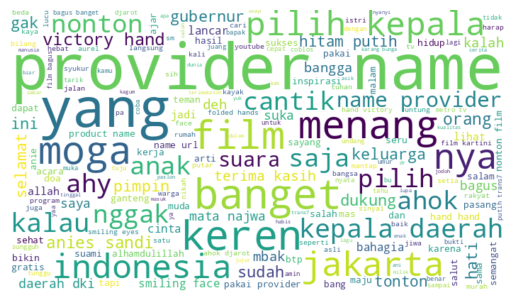

In [506]:
wordcloud(preprocessed_data, 'Sentiment', 'positive', 'Tweet')

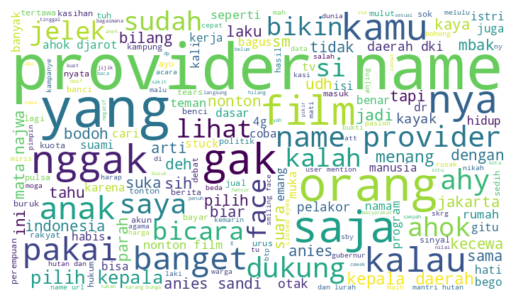

In [507]:
wordcloud(preprocessed_data, 'Sentiment', 'negative', 'Tweet')

In [508]:
import nltk
from nltk.corpus import stopwords

# Download the stop words corpus if not already downloaded
nltk.download('stopwords')

# Get the list of stop words
stop_words = set(['a',
                         'b', 'bikin', 'banget',
                         'c',
                         'd',
                         'e',
                         'f', 'face', 'film',
                         'g', 'gak',
                         'h', 'hand', 'hitam',
                         'i',
                         'j',
                         'k', 'khusus', 'kepala', 'keluarga','kalau', 'kamu',
                         'l', 'lagi',
                         'm', 'mata', 'mbak',
                         'n', 'name', 'nonton','nggak', 'nya',
                         'o', 'orang',
                         'p', 'provider', 'putih', 'pak',
                         'q',
                         'r',
                         's', 'smilling', 'si','saja', 'saya','sih',
                         't',
                         'u', 'username',
                         'v',
                         'w', 'with',
                         'x',
                         'y', 'yang',
                         'z'])
# Remove stop words from a DataFrame column
preprocessed_data["Tweet"] = preprocessed_data["Tweet"].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# VSM

In [509]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vsm = vectorizer.fit_transform(preprocessed_data["Tweet"])
vsm = vsm[vsm.getnnz(1) > 0][:, vsm.getnnz(0) > 0]  # Remove zero rows and columns
print(vsm.shape)
print(str(vectorizer.vocabulary_)[:200])

(2177, 19487)
{'tolol': 18180, 'hubung': 7032, 'gugur': 6377, 'dengan': 4662, 'pakai': 13245, 'hijab': 6918, 'syar': 17253, 'bilang': 2958, 'bayi': 2404, 'panas': 13374, 'dalem': 4344, 'woyyyy': 19282, 'otak': 1315


# TRAIN AND TEST

In [510]:
# Bentuk VSM-nya
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',smooth_idf= True, sublinear_tf=True,
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

In [511]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
seed = 7

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data["Tweet"], preprocessed_data["Sentiment"], test_size=0.3, random_state=seed)
x_train = tfidf_vectorizer.fit_transform(x_train) # "Fit_Transform"
x_test = tfidf_vectorizer.transform(x_test) # Perhatikan disini hanya "Transform"

print(x_train.shape, x_test.shape) # Jumlah kolom Sama ==> ini penting

(1540, 1976) (660, 1976)


In [512]:
def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

x_train, y_train = hapusKosong(x_train, y_train)
x_test, y_test = hapusKosong(x_test, y_test)
print(x_train.shape, x_test.shape)

(1508, 1976) (643, 1976)


# SVM + RANDOM FOREST NAIVE BAYES

In [513]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [514]:
# Naive Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
nbc = gnb.fit(x_train.toarray(), y_train) # Kelemahan Implementasinya disini

y_nbc = nbc.predict(x_test.toarray())

print('Akurasi = ', accuracy_score(y_test, y_nbc))
print(confusion_matrix(y_test, y_nbc))
print(classification_report(y_test, y_nbc))
# Hati-hati Sparse ==> Dense bisa memenuhi memory untuk data relatif cukup besar
# Akurasi cukup baik

Akurasi =  0.702954898911353
[[180 143]
 [ 48 272]]
              precision    recall  f1-score   support

    negative       0.79      0.56      0.65       323
    positive       0.66      0.85      0.74       320

    accuracy                           0.70       643
   macro avg       0.72      0.70      0.70       643
weighted avg       0.72      0.70      0.70       643



In [515]:
# Mari coba perbaiki dengan Random Forest
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)
y_RF = RandomForest.predict(x_test)
print('Akurasi = ', accuracy_score(y_test, y_RF))
print(confusion_matrix(y_test, y_RF))
print(classification_report(y_test, y_RF))
# Sedikit membaik (expected)

Akurasi =  0.76049766718507
[[256  67]
 [ 87 233]]
              precision    recall  f1-score   support

    negative       0.75      0.79      0.77       323
    positive       0.78      0.73      0.75       320

    accuracy                           0.76       643
   macro avg       0.76      0.76      0.76       643
weighted avg       0.76      0.76      0.76       643



In [516]:
from sklearn import svm

dSVM = svm.SVC(decision_function_shape='ovo')
dSVM.fit(x_train, y_train)
y_SVM = dSVM.predict(x_test)
print('Akurasi = ', accuracy_score(y_test, y_SVM))
print(confusion_matrix(y_test, y_SVM))
print(classification_report(y_test, y_SVM))

Akurasi =  0.7869362363919129
[[245  78]
 [ 59 261]]
              precision    recall  f1-score   support

    negative       0.81      0.76      0.78       323
    positive       0.77      0.82      0.79       320

    accuracy                           0.79       643
   macro avg       0.79      0.79      0.79       643
weighted avg       0.79      0.79      0.79       643



# ENSEMBLE

In [517]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluate(model, x_train, x_test, y_train, y_test):
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

## VOTING (PERFORMA MODEL)

In [518]:
from sklearn.ensemble import VotingClassifier
estimators = []

estimators.append(('Random Forest', RandomForest))

estimators.append(('Naive Bayes', gnb))

estimators.append(('SVM', dSVM))

voting = VotingClassifier(estimators=estimators)
voting.fit(x_train.toarray(), y_train)

evaluate(voting, x_train.toarray(), x_test.toarray(), y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[766   7]
 [  0 735]]
ACCURACY SCORE:
0.9954
CLASSIFICATION REPORT:
             negative    positive  accuracy    macro avg  weighted avg
precision    1.000000    0.990566  0.995358     0.995283      0.995402
recall       0.990944    1.000000  0.995358     0.995472      0.995358
f1-score     0.995452    0.995261  0.995358     0.995356      0.995359
support    773.000000  735.000000  0.995358  1508.000000   1508.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[241  82]
 [ 54 266]]
ACCURACY SCORE:
0.7885
CLASSIFICATION REPORT:
             negative    positive  accuracy   macro avg  weighted avg
precision    0.816949    0.764368  0.788491    0.790658      0.790781
recall       0.746130    0.831250  0.788491    0.788690      0.788491
f1-score     0.779935    0.796407  0.788491    0.788171      0.788133
support    323.000000  320.000000  0.788491  643.000000    643.000000


In [519]:
scores['voting'] = {
    'Train': accuracy_score(y_train, voting.predict(x_train.toarray())),
    'Test': accuracy_score(y_test, voting.predict(x_test.toarray())),
}


## BOOSTING

In [520]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_clf = GradientBoostingClassifier(n_estimators=100, random_state=7)
grad_boost_clf.fit(x_train, y_train)
evaluate(grad_boost_clf, x_train, x_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[754  19]
 [238 497]]
ACCURACY SCORE:
0.8296
CLASSIFICATION REPORT:
             negative    positive  accuracy    macro avg  weighted avg
precision    0.760081    0.963178  0.829576     0.861629      0.859071
recall       0.975420    0.676190  0.829576     0.825805      0.829576
f1-score     0.854391    0.794564  0.829576     0.824478      0.825231
support    773.000000  735.000000  0.829576  1508.000000   1508.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[274  49]
 [133 187]]
ACCURACY SCORE:
0.7170
CLASSIFICATION REPORT:
             negative    positive  accuracy   macro avg  weighted avg
precision    0.673219    0.792373  0.716952    0.732796      0.732518
recall       0.848297    0.584375  0.716952    0.716336      0.716952
f1-score     0.750685    0.672662  0.716952    0.711673      0.711855
support    323.000000  320.000000  0.716952  643.000000    643.000000


In [521]:
scores['Gradient Boosting'] = {
    'Train': accuracy_score(y_train, grad_boost_clf.predict(x_train)),
        'Test': accuracy_score(y_test, grad_boost_clf.predict(x_test)),
}


<Axes: >

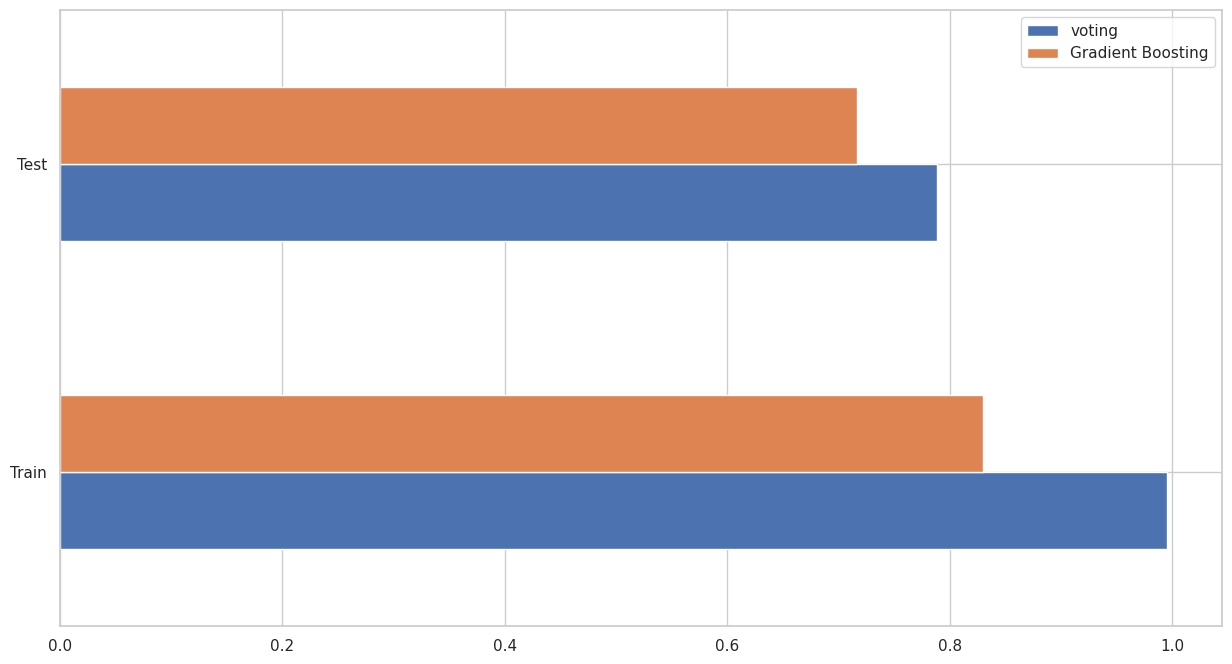

In [522]:
scores_df = pd.DataFrame(scores)

scores_df.plot(kind='barh', figsize=(15, 8))

# MODELING

## WORDCLOUD

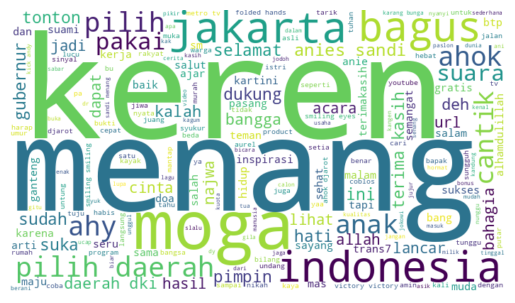

In [523]:
wordcloud(preprocessed_data, 'Sentiment', 'positive', 'Tweet')

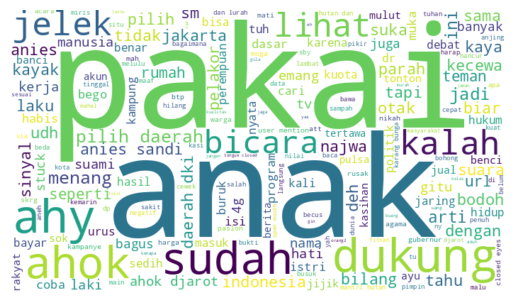

In [524]:
wordcloud(preprocessed_data, 'Sentiment', 'negative', 'Tweet')

## N-GRAMS

In [525]:
ngram = tokenization(preprocessed_data)
ngram[:5]

['tolol', 'hubung', 'gugur', 'dengan', 'pakai']

Text(0.5, 0, 'Jumlah Kata')

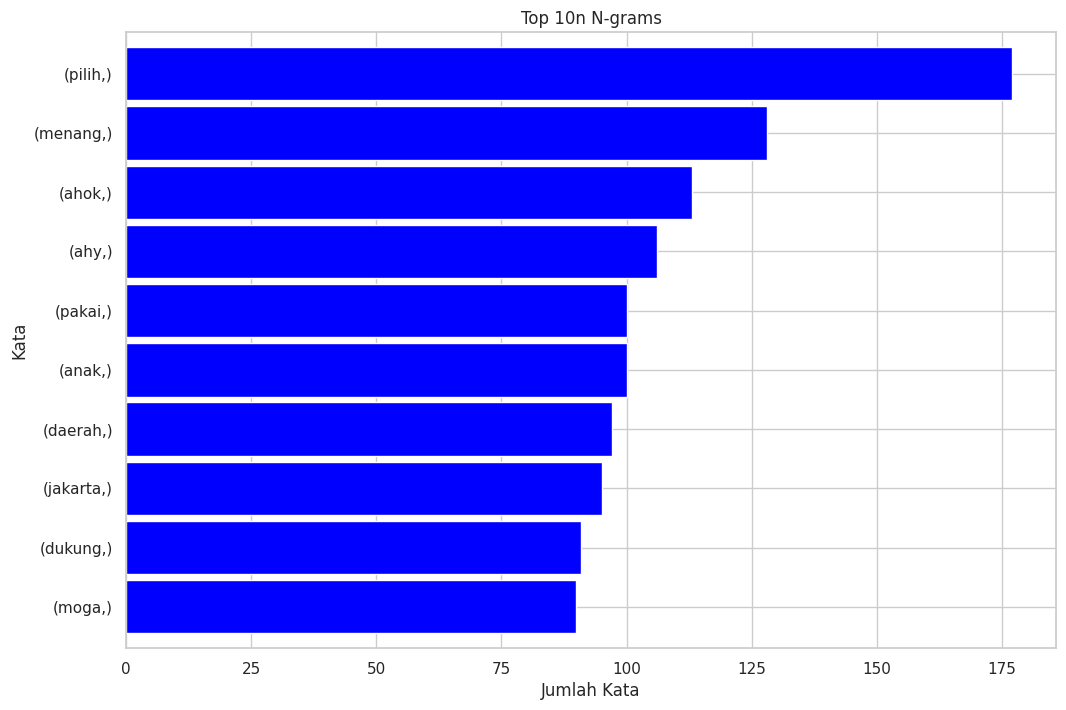

In [526]:
n1=  (pd.Series(nltk.ngrams(ngram, 1)).value_counts())[:10]
ax = n1.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Top 10n N-grams')
plt.ylabel('Kata')
plt.xlabel('Jumlah Kata')

## BARPLOT

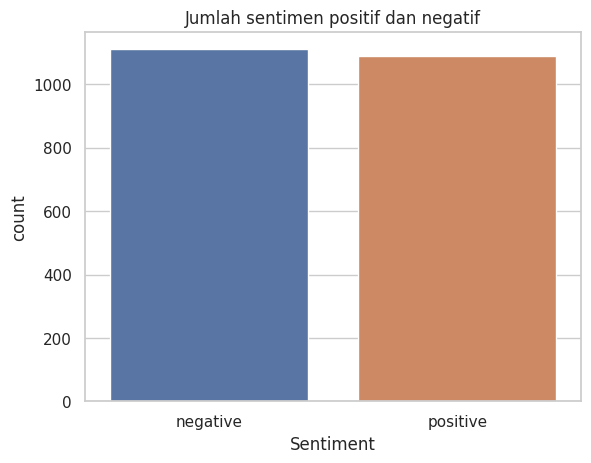

In [527]:
preprocessed_data["Sentiment"].value_counts()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x=preprocessed_data["Sentiment"])
plt.title('Jumlah sentimen positif dan negatif')
plt.show()

<h1>DASH</h1>


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import nltk
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px


nltk.download('punkt')
nltk.download('stopwords')

data = pd.read_csv('https://raw.githubusercontent.com/Anisabilaaa/Projek-Akhir-Analisa-Media-Sosial-AMS-/main/DataProjek%20(1).csv')

df_sent = pd.DataFrame({
    "Sentiment": ["Positive", "Negative"],
    "Amount": [data["Sentiment"].value_counts()["Positive"], data["Sentiment"].value_counts()["Negative"]],
})



# Mengonversi kolom teks menjadi string
data['Tweet'] = data['Tweet'].astype(str)

# Mengidentifikasi sentimen menggunakan SentimentIntensityAnalyzer dari NLTK
sia = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['Tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Filter teks dengan sentimen negatif
negative_data = data[data['sentiment_score'] < 0]

word_freq_negative = {}
for text in negative_data['Tweet']:
    words = text.split()
    for word in words:
        if word in word_freq_negative:
            word_freq_negative[word] += 1
        else:
            word_freq_negative[word] = 1

# Filter teks dengan sentimen positif
positive_data = data[data['sentiment_score'] > 0]

word_freq_positive = {}
for text in positive_data['Tweet']:
    words = text.split()
    for word in words:
        if word in word_freq_positive:
            word_freq_positive[word] += 1
        else:
            word_freq_positive[word] = 1

wordcloud_negative= WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq_negative)

wordcloud_positive= WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq_positive)

report = {
    'negative': {
        'precision': 1.000000,
        'recall': 0.990944,
        'f1-score': 0.995452,
        'support': 773
    },
    'positive': {
        'precision': 0.990566,
        'recall': 1.000000,
        'f1-score': 0.995261,
        'support': 735
    },
    'accuracy': 0.9954,
    'macro avg': {
        'precision': 0.995283,
        'recall': 0.995472,
        'f1-score': 0.995356,
        'support': 1508
    },
    'weighted avg': {
        'precision': 0.995402,
        'recall': 0.995358,
        'f1-score': 0.995359,
        'support': 1508
    }
}


df_prec = pd.DataFrame({
    "Performa": ["Precision", "Precision"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["precision"], report["negative"]["precision"]]})
df_rec = pd.DataFrame({
    "Performa": ["Recall", "Recall"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["recall"], report["negative"]["recall"]]})
df_sco = pd.DataFrame({
    "Performa": ["F1-Score", "F1-Score"],
    "Sentiment": ["Positive", "Negative"],
    "Percentage": [report["positive"]["f1-score"], report["negative"]["f1-score"]]})
df_perf = pd.concat([df_prec, df_rec, df_sco], ignore_index=True)

fig_sent = px.bar(df_sent, x="Sentiment", y="Amount", color="Sentiment",
             color_discrete_map={"Positive": "#6495ED", "Negative": "#CD5C5C"})

app = dash.Dash(_name_)

app.layout = html.Div([
    html.H1('Word Cloud - Sentimen Negatif'),
    dcc.Graph(
        id='wordcloud-graph',
        figure=go.Figure(data=go.Image(z=wordcloud_negative.to_array()))
    ),
    html.H2('Word Cloud - Sentimen Positif'),
    dcc.Graph(
        id='wordcloud-graph',
        figure=go.Figure(data=go.Image(z=wordcloud_positive.to_array()))
    ),
    html.H3(children='Final Project Analisis Media Sosial 2023', style={'textAlign':'center'}),
    html.Div(children='Metode Naive Bayes', style={'textAlign':'center'}),
    html.Label('BarPlot Banyaknya Sentimen Positif dan Negatif'),
    dcc.Graph(
        id='example-graph',
        figure=fig_sent
    ),
    html.Br(),
    html.Label('Performa Model'),
    html.Div(children='Accuracy: {}'.format(report["accuracy"])),
    dcc.Dropdown(options=[{'label': 'Precision', 'value': 'Precision'},
                          {'label': 'Recall', 'value': 'Recall'},
                          {'label': 'F1-Score', 'value': 'F1-Score'}],
                 value='Precision', id='dropdown-selection'),
    dcc.Graph(
        id='graph-content'
    )
])

@app.callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = df_perf[df_perf.Performa == value]
    return px.bar(dff, x="Sentiment", y="Percentage", color="Sentiment",
                  color_discrete_map={"Positive": "#6495ED", "Negative": "#CD5C5C"})

if _name_ == '_main_':
    app.run_server(debug=True)